In [2]:
#OS libs
import os
import shutil
import itertools
import pathlib


#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

In [3]:
# Generate train data paths with labels
train_data_dir = '/home/simon/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
test_data_dir = '/home/simon/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( dataframe=train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( dataframe=test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 9605 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


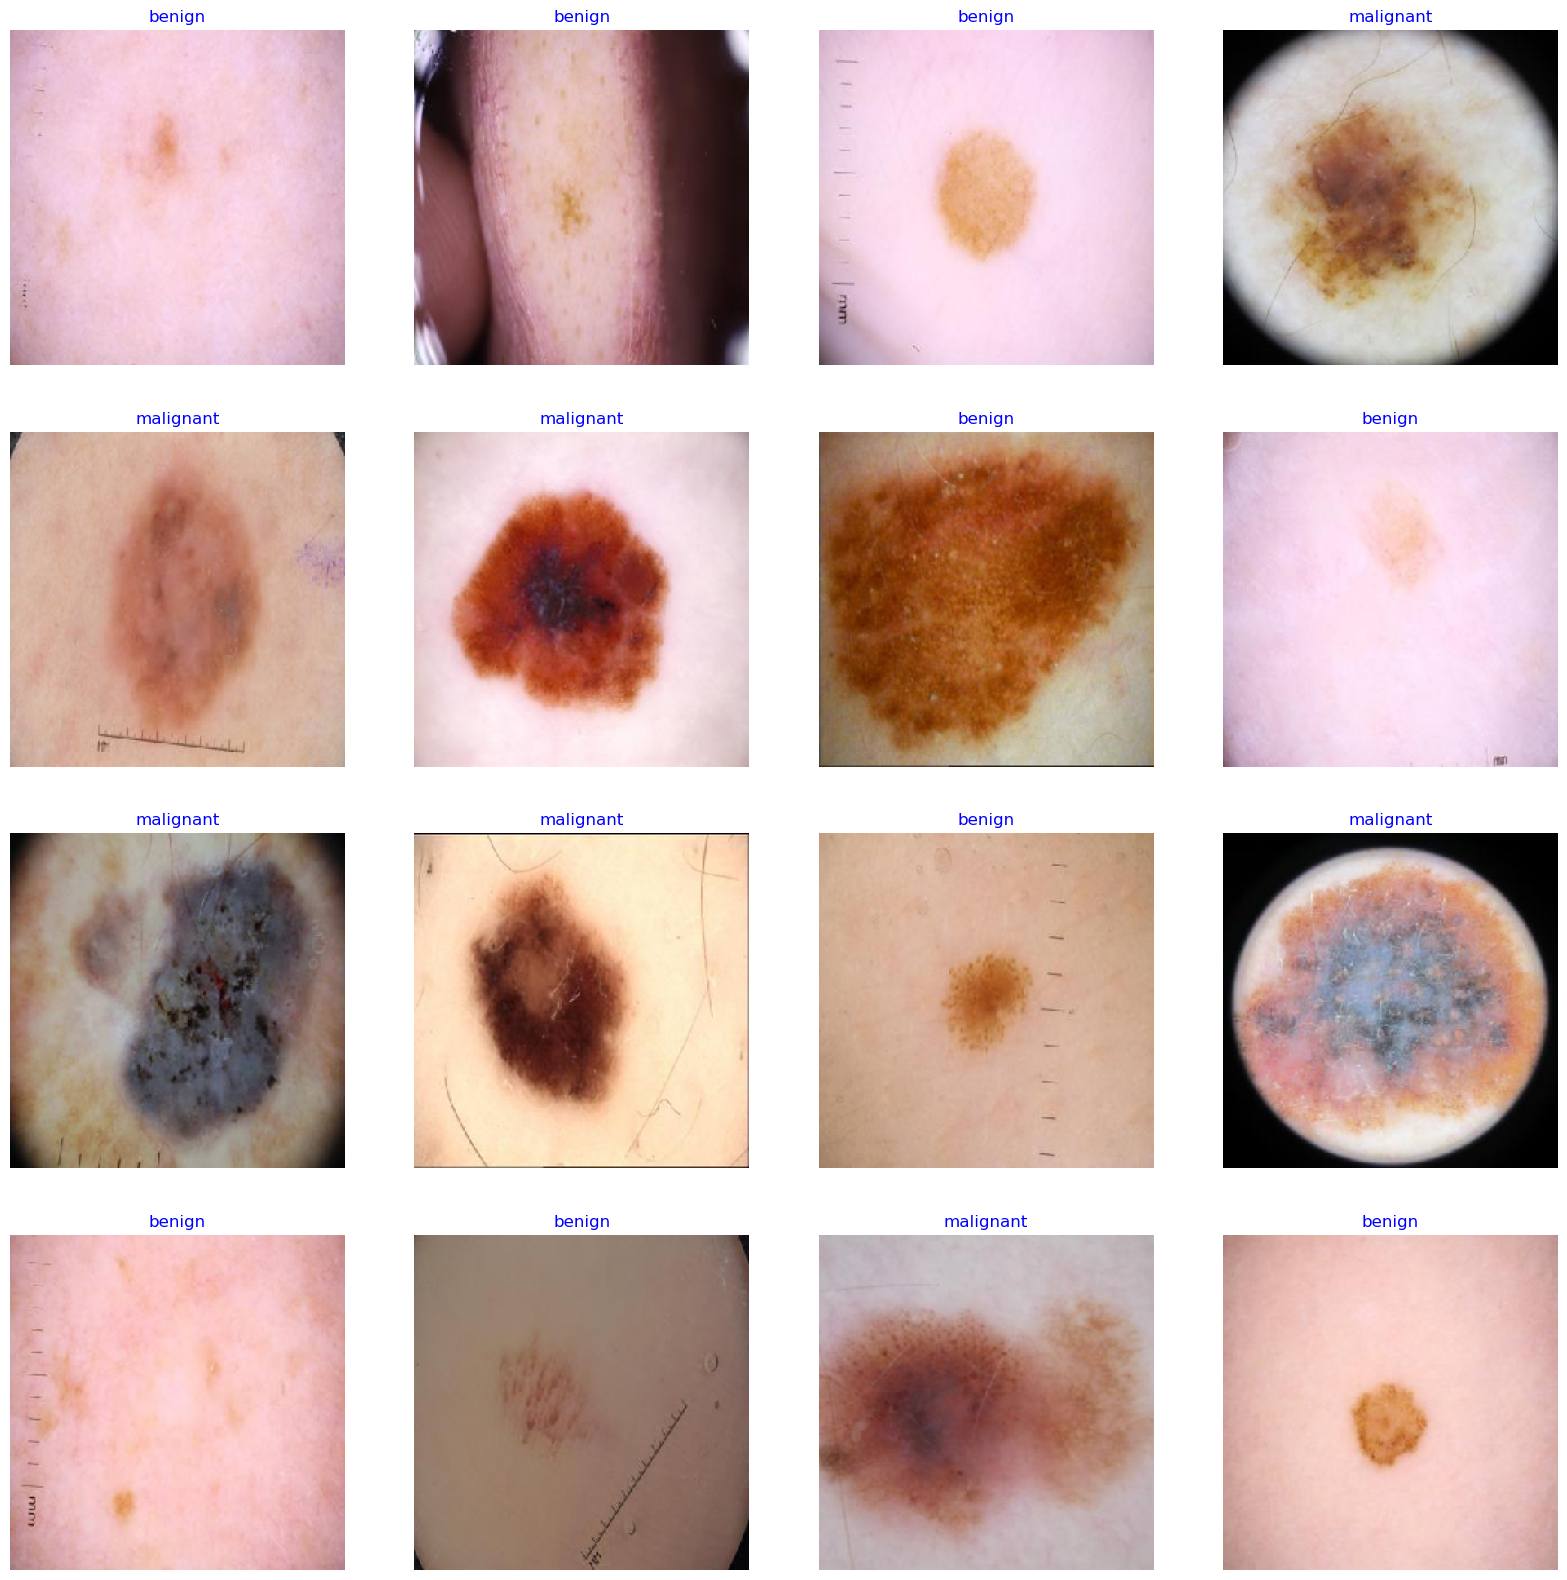

In [6]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# Load the MobileNetV2 model with pre-trained weights, excluding the top fully connected layers
base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(512, activation='relu'),  # Add a dense layer
    Dropout(0.5),  # Add dropout for regularization
    Dense(class_count, activation='softmax')  # Output layer for binary classification (benign vs malignant)
])

2025-04-04 12:02:48.255264: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
 #Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,002 (11.14 MB)

 Trainable params: 659,458 (2.52 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [10]:
EPOCHS = 10
# Train the model
history = model.fit(x= train_gen, epochs= EPOCHS, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)



Epoch 1/10


/home/simon/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


601/601 ━━━━━━━━━━━━━━━━━━━━ 97s 147ms/step - accuracy: 0.7744 - loss: 0.6397 - val_accuracy: 0.8740 - val_loss: 0.3039
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.8587 - loss: 0.3669 - val_accuracy: 0.8800 - val_loss: 0.3132
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.8730 - loss: 0.3049 - val_accuracy: 0.8690 - val_loss: 0.2948
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.8766 - loss: 0.3070 - val_accuracy: 0.8420 - val_loss: 0.4247
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.8784 - loss: 0.2967 - val_accuracy: 0.8820 - val_loss: 0.3489
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.8898 - loss: 0.2746 - val_accuracy: 0.8900 - val_loss: 0.3232
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - accuracy: 0.8986 - loss: 0.2505 - val_accuracy: 0.8830 - val_loss: 0.3350
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - accuracy: 0.9020 - loss: 0.2433 - val_accura

In [12]:
EPOCHS = 10
# Train the model
history2 = model.fit(x= train_gen, epochs= EPOCHS, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/10
 33/601 ━━━━━━━━━━━━━━━━━━━━ 1:04 114ms/step - accuracy: 0.9432 - loss: 0.1536

KeyboardInterrupt: 